In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import gdown
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

In [1]:
# =================================================
# 1) 파일 자동 다운로드 (Google Drive -> Colab)
# =================================================

In [ ]:
FILE_IDS = {
    "mon_standard.pkl": "1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63",
    "unmon_standard10.pkl": "1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn",
}

try:
    gdown.download_folder
except:
    !pip install gdown

def download_data_for_colab():
    print("\n 데이터 파일 자동 다운로드 시작...")
    for filename, file_id in FILE_IDS.items():
        filepath = f"/content/{filename}"
        if not os.path.exists(filepath):
            print(f"Downloading {filename} ...")
            !gdown --id $file_id -O $filepath --fuzzy
            print(f" {filename} download complete.")
        else:
            print(f" {filename} already exists. Skip.")

In [ ]:
# =================================================
# 2) Feature Extraction Utilities
# =================================================

In [5]:
def compute_bursts(size_seq):
    if len(size_seq) == 0:
        return []
    bursts = []
    current_sign = np.sign(size_seq[0])
    current_sum = size_seq[0]
    for s in size_seq[1:]:
        sign = np.sign(s)
        if sign == current_sign:
            current_sum += s
        else:
            bursts.append(current_sum)
            current_sum = s
            current_sign = sign
    bursts.append(current_sum)
    return bursts

def compute_zero_crossings(arr):
    if len(arr) == 0:
        return 0
    sgn = np.sign(arr)
    for i in range(len(sgn)):
        if sgn[i] == 0:
            sgn[i] = sgn[i - 1] if i > 0 else 0
    return np.sum(np.diff(sgn) != 0)


In [ ]:
# ------------------------------------
# 특징 추출 함수
# ------------------------------------

In [6]:
def extract_features_one_trace(times, sizes, initial_k=30):
    times = np.array(times)
    sizes = np.array(sizes)
    n_packets = len(sizes)

    if n_packets == 0:
        return {f: 0.0 for f in [
            "n_total","n_out","n_in","ratio_out_in","frac_out",
            "mean_inter_time","std_inter_time","min_inter_time","max_inter_time",
            "n_bursts","mean_burst_interval",
            "initial_n_out","initial_n_in","initial_mean_inter_time","initial_std_inter_time",
            "cum_final","cum_abs_sum","cum_max_abs","cum_zero_crossings"
        ]}

    # 패킷 개수 관련
    n_out = np.sum(sizes > 0)
    n_in = np.sum(sizes < 0)
    ratio_out_in = n_out / max(n_in, 1)
    frac_out = n_out / n_packets

    # 시간 간격 특징
    if len(times) >= 2:
        inter = np.diff(times)
        mean_inter = float(np.mean(inter))
        std_inter = float(np.std(inter))
        min_inter = float(np.min(inter))
        max_inter = float(np.max(inter))
    else:
        mean_inter = std_inter = min_inter = max_inter = 0.0

    # Bursts
    bursts = compute_bursts(sizes)
    n_bursts = len(bursts)
    mean_burst_interval = 0.0
    if n_bursts >= 2:
        burst_starts = [0]
        cur_sign = np.sign(sizes[0])
        for i in range(1, n_packets):
            if np.sign(sizes[i]) != cur_sign:
                burst_starts.append(i)
                cur_sign = np.sign(sizes[i])
        burst_times = times[burst_starts]
        if len(burst_times) >= 2:
            mean_burst_interval = float(np.mean(np.diff(burst_times)))

    # 초기 K 패킷 특징
    k = min(initial_k, n_packets)
    sizes0 = sizes[:k]
    times0 = times[:k]
    initial_n_out = int(np.sum(sizes0 > 0))
    initial_n_in = int(np.sum(sizes0 < 0))

    if k >= 2:
        inter0 = np.diff(times0)
        initial_mean_inter = float(np.mean(inter0))
        initial_std_inter = float(np.std(inter0))
    else:
        initial_mean_inter = initial_std_inter = 0.0

    # 누적 합 특징
    cum = np.cumsum(sizes)

    return {
        "n_total": int(n_packets),
        "n_out": int(n_out),
        "n_in": int(n_in),
        "ratio_out_in": ratio_out_in,
        "frac_out": frac_out,
        "mean_inter_time": mean_inter,
        "std_inter_time": std_inter,
        "min_inter_time": min_inter,
        "max_inter_time": max_inter,
        "n_bursts": int(n_bursts),
        "mean_burst_interval": mean_burst_interval,
        "initial_n_out": initial_n_out,
        "initial_n_in": initial_n_in,
        "initial_mean_inter_time": initial_mean_inter,
        "initial_std_inter_time": initial_std_inter,
        "cum_final": float(cum[-1]),
        "cum_abs_sum": float(np.sum(np.abs(cum))),
        "cum_max_abs": float(np.max(np.abs(cum))),
        "cum_zero_crossings": compute_zero_crossings(cum)
    }

def build_feature_dataframe(X1, X2):
    return pd.DataFrame([extract_features_one_trace(t, s) for t, s in zip(X1, X2)])


In [ ]:
# =================================================
# 3) 시각화 함수
# =================================================


In [7]:
def plot_confusion_matrix(y_test, y_pred, title_prefix, labels=['Unmon (0)', 'Mon (1)']):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

def plot_curves(y_test, y_score, title_prefix):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr)
    plt.title(f"{title_prefix} ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.show()

    prec, rec, _ = precision_recall_curve(y_test, y_score)
    plt.plot(rec, prec)
    plt.title(f"{title_prefix} Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


In [ ]:
# =================================================
# 4) 데이터 로드 + 특징추출 통합
# =================================================

In [10]:
def load_and_preprocess_data(
    file_path, max_len, total_urls, is_monitored,
    url_per_site=10, sample_size=None
):
    print(f"\n Loading {file_path}")
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    X1_seq, X2_seq, labels = [], [], []

    indices = np.random.choice(total_urls, sample_size, replace=False) if sample_size else range(total_urls)
    data = [data[i] for i in indices]

    for i, entry in enumerate(data):
        if is_monitored:
            label = i // url_per_site
            samples = entry
        else:
            label = -1
            samples = [entry]

        for seq in samples:
            size_seq = []
            time_seq = []
            for c in seq[:max_len]:
                direction = 1 if c > 0 else -1
                time_seq.append(abs(c))
                size_seq.append(direction * 512)

            X1_seq.append(time_seq)
            X2_seq.append(size_seq)
            if is_monitored:
                labels.append(label)

    print("Total samples:", len(X1_seq))
    return X1_seq, X2_seq, np.array(labels)


In [ ]:
# =================================================
# 5) 데이터 로드 및 특징추출 실행
# =================================================

In [11]:
download_data_for_colab()

MON_FILE = "/content/mon_standard.pkl"
UNMON_FILE = "/content/unmon_standard10.pkl"

X1_mon, X2_mon, y_mon = load_and_preprocess_data(
    MON_FILE, 1500, 950, True, url_per_site=10, sample_size=190
)
mon_features = build_feature_dataframe(X1_mon, X2_mon)

X1_unmon, X2_unmon, _ = load_and_preprocess_data(
    UNMON_FILE, 2000, 10000, False, sample_size=500
)
unmon_features = build_feature_dataframe(X1_unmon, X2_unmon)

print("\n Feature Extraction Completed!")
print(mon_features.head())


📦 데이터 파일 자동 다운로드 시작...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63
From (redirected): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63&confirm=t&uuid=1cbbecd2-3c8b-465e-8a13-224ea5931dda
To: /content/mon_standard.pkl
100% 717M/717M [00:09<00:00, 79.2MB/s]
✅ mon_standard.pkl download complete.
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn
From (redirected): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn&confirm=t&uui

In [12]:
# =================================================
# 6) Gradient Boosting – Closed-world (95-class)
# =================================================


In [13]:
print("\n\n===== CLOSED-WORLD : Gradient Boosting =====")

X_cw = mon_features.values
y_cw = y_mon

X_train_cw, X_test_cw, y_train_cw, y_test_cw = train_test_split(
    X_cw, y_cw, test_size=0.2, stratify=y_cw, random_state=42
)

scaler_cw = StandardScaler()
X_train_cw = scaler_cw.fit_transform(X_train_cw)
X_test_cw = scaler_cw.transform(X_test_cw)

# Baseline
gb_base = GradientBoostingClassifier(random_state=42)
gb_base.fit(X_train_cw, y_train_cw)
pred_base = gb_base.predict(X_test_cw)

print("Baseline Acc:", accuracy_score(y_test_cw, pred_base))

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0]
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_cw, y_train_cw)
best_gb_cw = grid.best_estimator_

print("Best Params:", grid.best_params_)
pred_gb = best_gb_cw.predict(X_test_cw)
print("Final Accuracy:", accuracy_score(y_test_cw, pred_gb))



===== CLOSED-WORLD : Gradient Boosting =====
Baseline Acc: 0.43026315789473685
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Final Accuracy: 0.41710526315789476


In [ ]:
# =================================================
# 7) Open-world (Binary Classification)
# =================================================



===== OPEN-WORLD : Gradient Boosting =====
Precision: 0.9809688581314879
Recall: 0.9947368421052631
F1: 0.9878048780487805
ROC-AUC: 0.9914766081871346


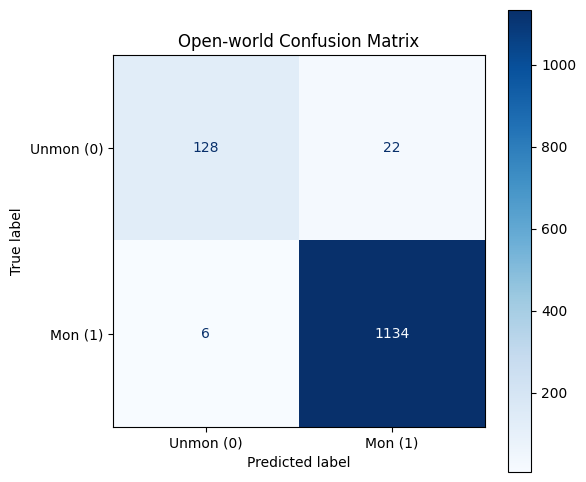

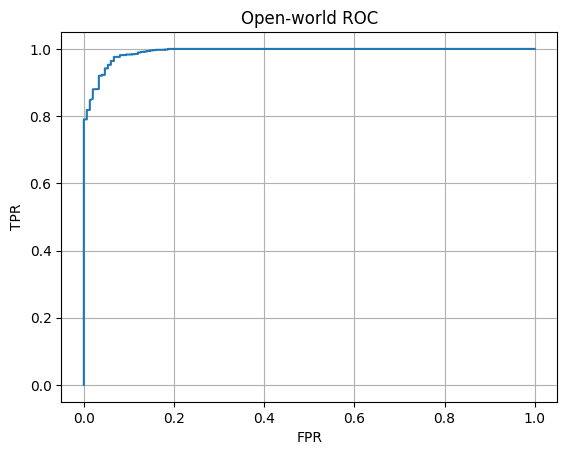

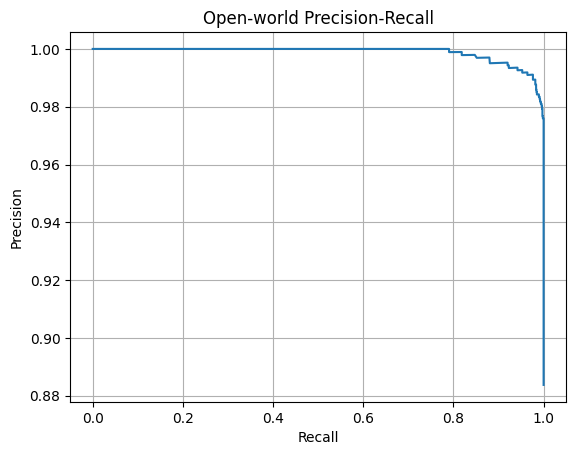

In [14]:
print("\n\n===== OPEN-WORLD : Gradient Boosting =====")

mon_df = mon_features.copy()
mon_df["label"] = 1

unmon_df = unmon_features.copy()
unmon_df["label"] = 0

df_open = pd.concat([mon_df, unmon_df])

X_open = df_open.drop("label", axis=1).values
y_open = df_open["label"].values

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_open, y_open, test_size=0.3, stratify=y_open, random_state=42
)

scaler_o = StandardScaler()
X_train_o = scaler_o.fit_transform(X_train_o)
X_test_o = scaler_o.transform(X_test_o)

gb_o = GradientBoostingClassifier(random_state=42)
gb_o.fit(X_train_o, y_train_o)

pred_o = gb_o.predict(X_test_o)
score_o = gb_o.predict_proba(X_test_o)[:,1]

print("Precision:", precision_score(y_test_o, pred_o))
print("Recall:", recall_score(y_test_o, pred_o))
print("F1:", f1_score(y_test_o, pred_o))
print("ROC-AUC:", roc_auc_score(y_test_o, score_o))

plot_confusion_matrix(y_test_o, pred_o, "Open-world")
plot_curves(y_test_o, score_o, "Open-world")

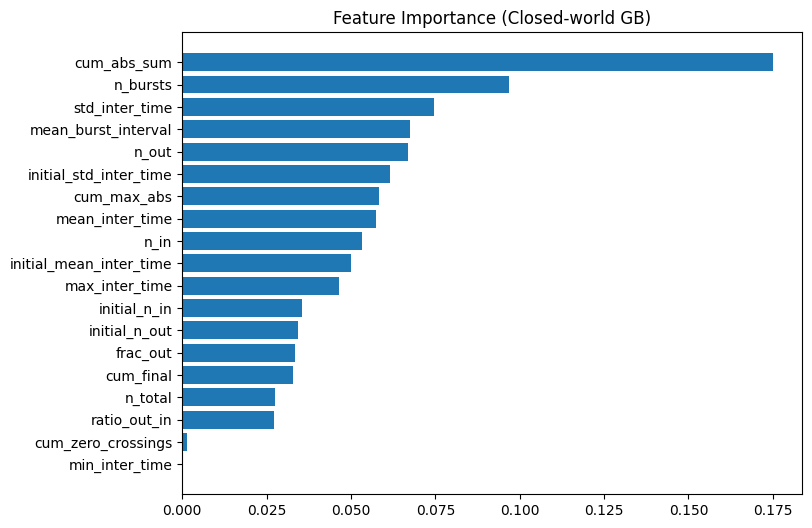

In [19]:
# =================================================
# 8) Feature Importance
# =================================================
plt.figure(figsize=(8,6))
importances = best_gb_cw.feature_importances_
idx = np.argsort(importances)[::-1]
plt.barh(mon_features.columns[idx], importances[idx])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Closed-world GB)")
plt.show()

In [20]:
# =================================================
# 9) SHAP Explanation
# =================================================


 Running SHAP for Open-world GB model (binary)...


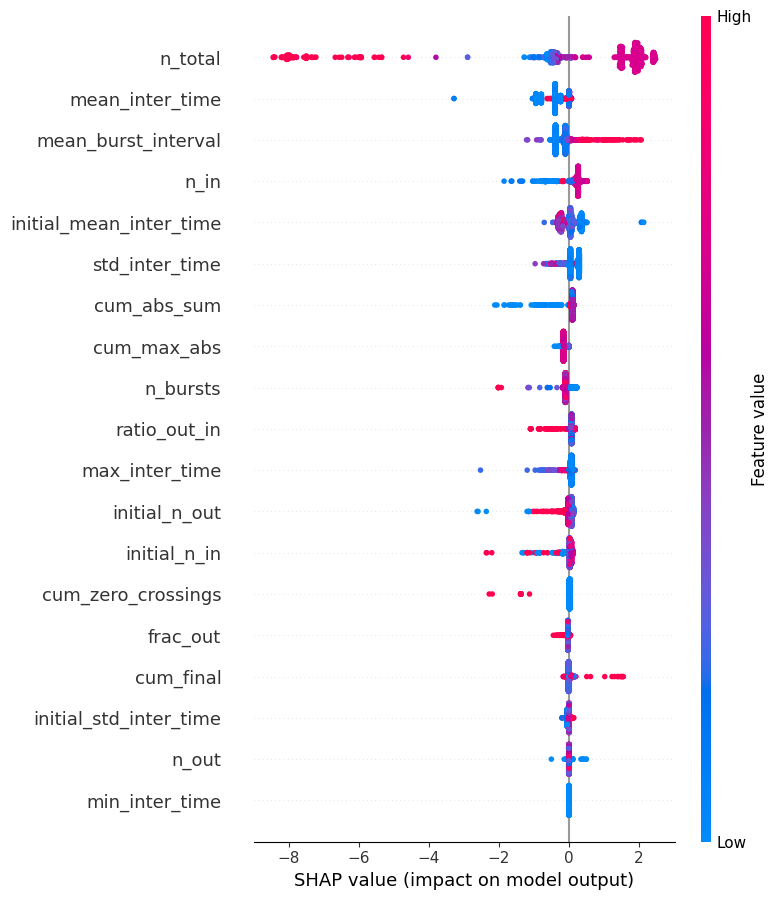

In [23]:
import shap

print("\n Running SHAP for Open-world GB model (binary)...")

explainer = shap.TreeExplainer(gb_o)     # binary model -> SHAP 지원 O
shap_values = explainer.shap_values(X_test_o)

shap.summary_plot(
    shap_values,
    X_test_o,
    feature_names=df_open.drop("label", axis=1).columns
)